In dit notebook gaan we financiële niews artikelen proberen te classificeren aan de hand van een word2vec model. Eerst gaan er pre-processing stappen plaats vinden om de data schoon te maken zodat dit gebruikt kan worden voor het trainen van het llm model. Dit llm model wordt dan gebruikt om features te maken zodat deze gebruikt kunnen worden door een classificatie model. Dit model probeert dan te voorspellen wat het sentiment is van een nieuws artikel en wordt vervolgens gebruikt om een advies te genereren (via een ander model/notebook die later samen gevoegd gebracht worden middels een API). Dit notebook is puur voor het trainen het/de model(len).

Om een begin te maken aan dit notebook is er gebruik gemaakt van een financial news dataset [1] op kaggle om dit model op te trainen. Ook is dit notebook gebasseerd op tutorials van kaggle [2][3] en zijn er aanpassing gemaakt zodat dit kan werken op ons probleem.

In [86]:
#Import libraries

import re    # for regular expressions
import nltk  # for text manipulation
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import string
import re
from deep_translator import GoogleTranslator
from gensim.models import word2vec
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from lime.lime_text import LimeTextExplainer

nltk.download('stopwords')
nltk.download('punkt_tab')

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ramir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Als eerst wordt de besproken dataset van financieel nieuws ingeladen. Als extra bijkomstigheid laden we ook 2 woorden lijsten [4] in die al geclassificeerd zijn als positief of negatief (Alle woorden die hier niet tussen staan worden als neutraal beschouwd)

In [87]:
# Download latest version
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")

print("Path to dataset files:", path)

postive_words_file = open("positive-words.txt", "r")
negative_words_file = open("negative-words.txt", "r")

postive_words = postive_words_file.readlines()
negative_words = negative_words_file.readlines()

postive_words = set(map(lambda w: w.replace("\n", ""), postive_words))
negative_words = set(map(lambda w: w.replace("\n", ""), negative_words))
negation_words = set([
    "no",
    "not",
    "neither",
    "nor",
    "none",
    "nothing",
    ]) # Just an example set


Path to dataset files: C:\Users\ramir\.cache\kagglehub\datasets\ankurzing\sentiment-analysis-for-financial-news\versions\5


Voordat we verder gaat met de rest moeten we eerst even naar het gegeven pad gaan om de file "all-data.csv" te kopiëren naar het project. Het direct gebruik maken van het pad voor het lezen van de file geeft een permission denied error.

In [88]:
def translate_text(text):
    translator = GoogleTranslator(source='auto', target='en')
    translated = translator.translate(text)
    return translated

In [89]:
#read the data
df = pd.read_csv("all-data.csv", names=["sentiment", "text"],encoding="utf-8", encoding_errors="replace")
df = df[df['sentiment'] != 'neutral']

min_count = df['sentiment'].value_counts().min()
df = df.groupby('sentiment').sample(n=min_count, random_state=42)
df['text'] = df['text'].apply(translate_text)

df.reset_index(drop=True, inplace=True)

print(df['sentiment'].value_counts())

df

sentiment
negative    604
positive    604
Name: count, dtype: int64


,sentiment,text
0,negative,The company decided at the end of 2008 to temporarily shut down its ammonia plant in Billingham and extend the maintenance period at its Ince facility .
1,negative,down to EUR5 .9 m H1 '09 3 August 2009 - Finnish media group Ilkka-Yhtyma Oyj ( HEL : ILK2S ) said today its net profit fell 45 % on the year to EUR5 .9 m in the first half of 2009 .
2,negative,"The steelmaker said that the drop in profit was explained by the continuing economic uncertainty , mixed with the current drought in bank lending , resulting in a decline in demand for its product..."
3,negative,Finland-based Stockmann Group has closed seven franchising sports stores Nike in Russia .
4,negative,"Operating loss before non-recurring items was EUR 0.9 mn , compared to a profit of EUR 11.5 mn in 2008 ."
...,...,...
1203,positive,"Meanwhile , Electrowatt-Ekono Philippines , Inc. was also awarded a three-year operation and maintenance ( O&M ) contract by FR Cement Corporation ."
1204,positive,The company reports a loss for the period of EUR 0.4 mn compared to a loss of EUR 1.9 mn in the corresponding period in 2005 .
1205,positive,"29 September , 2010 Finnish waste management and recycling company Lassila & Tikanoja expands its operations in Russia by introducing its recently completed recycling plant in the city of Dubna ne..."
1206,positive,Last year SysOpen Digia invested in IBM product know-how in the building of portal and trading place systems and successfully implemented customer solutions supported by it .


Nu dat de data is ingelezen gaan we beginnen met data exploratie. 

In [90]:
# Mocht je een andere sentiment willen zien dan moet je de geactiveerde lijn commenten en de gewenste lijn uncommenten.

# Hoe zien de positieve sentimenten er uit
df[df["sentiment"] == "positive"]

# Hoe zien de neutrale sentimenten er uit
#df[df["sentiment"] == "neutral"]

# Hoe zien de negatieve sentimenten er uit
#df[df["sentiment"] == "negative"]


,sentiment,text
604,positive,"EBIT excluding non-recurring items , totalled EUR 67.8 mn , up from EUR 38.1 mn ."
605,positive,"` This is a repeat order to follow successfully installed 159 elevators in the same Delhi metro system , ' Kone spokeswoman told Thomson Financial News ."
606,positive,"According to Olvi 's Managing Director Lasse Aho , the company has an ongoing MMX Plus project that aims to find growth outside Finland ."
607,positive,"Systeemitiimi 's sales and project resources will also be strengthened , director Paul Skogberg said ."
608,positive,"The Lithuanian beer market made up 14.41 million liters in January , a rise of 0.8 percent from the year-earlier figure , the Lithuanian Brewers ' Association reporting citing the results from its..."
...,...,...
1203,positive,"Meanwhile , Electrowatt-Ekono Philippines , Inc. was also awarded a three-year operation and maintenance ( O&M ) contract by FR Cement Corporation ."
1204,positive,The company reports a loss for the period of EUR 0.4 mn compared to a loss of EUR 1.9 mn in the corresponding period in 2005 .
1205,positive,"29 September , 2010 Finnish waste management and recycling company Lassila & Tikanoja expands its operations in Russia by introducing its recently completed recycling plant in the city of Dubna ne..."
1206,positive,Last year SysOpen Digia invested in IBM product know-how in the building of portal and trading place systems and successfully implemented customer solutions supported by it .


Nu gaan we kijken naar hoeveel woorden elke tekst heeft. Na inspectie kunnen we zien dat de meeste teksten veel woorden hebben. Hier zouden we potentiëel goede word embedding maken.

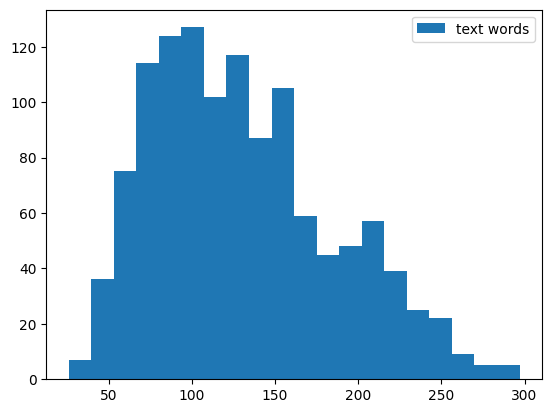

In [91]:
plt.hist(df.text.str.len(), bins=20, label='text words')
plt.legend()
plt.show()

Nu kunnen we gaan beginnen met de eerste pre-processing stappen. Om te beginnen wordt alles naar lower case gebracht en wordt interpunctie verwijderd. Later worden er stopwoorden verwijderd.

In [101]:



def lower_punctuation_no_numbers(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text


def remove_stop_words(text:str):
    stop_words = set(stopwords.words("english"))
    
    tokenized_text = word_tokenize(text)

    filtered_text = [w for w in tokenized_text if not w in stop_words]
    return filtered_text


# counts positive words in sentence
def add_positive_words(tokens):
    count = 0
    for token in tokens:
        if token in postive_words:
            count += 1
    return count

def find_positive_words(tokens):
    positive_words_found = []
    for token in tokens:
        if token in postive_words:
            positive_words_found.append(token)
    return positive_words_found

# counts negative words in sentence
def add_negative_words(tokens):
    count = 0
    for token in tokens:
        if token in negative_words:
            count += 1
    return count

def find_negative_words(tokens):
    negative_words_found = []
    for token in tokens:
        if token in negative_words:
            negative_words_found.append(token)
    return negative_words_found

# calculates average sentiment from text if value > 0 then positive, if value < 0 then negative, if value == 0 then neutral
def average_word_sentiment(tokens):
    if len(tokens) == 0:
        return 0
    pos = add_positive_words(tokens)
    neg = add_negative_words(tokens)
    avg = (pos-neg) / (len(tokens))
    return avg

def get_neg_indexes(words):
    indexes = []
    i = 0
    for word in words:
        if word in negation_words:
            indexes.append(i)
        i += 1
    return indexes

def antonyms(text:str):
    words = text.split()
    indexes = get_neg_indexes(words)
    while indexes != []:
        i = indexes[0]
        words[i+1] = wordnet
        words = words.pop(i)
        indexes = indexes.pop(0)
        indexes -= 1
        
    return

df["clean_text_tokenized"] = df["text"].apply(lower_punctuation_no_numbers)
df["clean_text_tokenized"] = df["clean_text_tokenized"].apply(remove_stop_words)
df["postive_word_count"]= df["clean_text_tokenized"].apply(add_positive_words)
df["positive_words"] = df["clean_text_tokenized"].apply(find_positive_words)
df["negative_word_count"] = df["clean_text_tokenized"].apply(add_negative_words)
df["negative_words"] = df["clean_text_tokenized"].apply(find_negative_words)
df["avg_sentiment_of_words"] = df["clean_text_tokenized"].apply(average_word_sentiment)

# map the sentiments to a number
mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}


df["labels"] = df["sentiment"].map(mapping)
df
    

,sentiment,text,clean_text_tokenized,postive_word_count,positive_words,negative_word_count,negative_words,avg_sentiment_of_words,labels
0,negative,The company decided at the end of 2008 to temporarily shut down its ammonia plant in Billingham and extend the maintenance period at its Ince facility .,"[company, decided, end, temporarily, shut, ammonia, plant, billingham, extend, maintenance, period, ince, facility]",0,[],0,[],0.000000,0
1,negative,down to EUR5 .9 m H1 '09 3 August 2009 - Finnish media group Ilkka-Yhtyma Oyj ( HEL : ILK2S ) said today its net profit fell 45 % on the year to EUR5 .9 m in the first half of 2009 .,"[eur, h, august, finnish, media, group, ilkkayhtyma, oyj, hel, ilks, said, today, net, profit, fell, year, eur, first, half]",0,[],1,[fell],-0.052632,0
2,negative,"The steelmaker said that the drop in profit was explained by the continuing economic uncertainty , mixed with the current drought in bank lending , resulting in a decline in demand for its product...","[steelmaker, said, drop, profit, explained, continuing, economic, uncertainty, mixed, current, drought, bank, lending, resulting, decline, demand, products, customers, find, increasingly, difficul...",0,[],3,"[drought, decline, difficult]",-0.130435,0
3,negative,Finland-based Stockmann Group has closed seven franchising sports stores Nike in Russia .,"[finlandbased, stockmann, group, closed, seven, franchising, sports, stores, nike, russia]",0,[],0,[],0.000000,0
4,negative,"Operating loss before non-recurring items was EUR 0.9 mn , compared to a profit of EUR 11.5 mn in 2008 .","[operating, loss, nonrecurring, items, eur, mn, compared, profit, eur, mn]",0,[],1,[loss],-0.100000,0
...,...,...,...,...,...,...,...,...,...
1203,positive,"Meanwhile , Electrowatt-Ekono Philippines , Inc. was also awarded a three-year operation and maintenance ( O&M ) contract by FR Cement Corporation .","[meanwhile, electrowattekono, philippines, inc, also, awarded, threeyear, operation, maintenance, om, contract, fr, cement, corporation]",1,[awarded],0,[],0.071429,2
1204,positive,The company reports a loss for the period of EUR 0.4 mn compared to a loss of EUR 1.9 mn in the corresponding period in 2005 .,"[company, reports, loss, period, eur, mn, compared, loss, eur, mn, corresponding, period]",0,[],2,"[loss, loss]",-0.166667,2
1205,positive,"29 September , 2010 Finnish waste management and recycling company Lassila & Tikanoja expands its operations in Russia by introducing its recently completed recycling plant in the city of Dubna ne...","[september, finnish, waste, management, recycling, company, lassila, tikanoja, expands, operations, russia, introducing, recently, completed, recycling, plant, city, dubna, near, moscow]",0,[],1,[waste],-0.050000,2
1206,positive,Last year SysOpen Digia invested in IBM product know-how in the building of portal and trading place systems and successfully implemented customer solutions supported by it .,"[last, year, sysopen, digia, invested, ibm, product, knowhow, building, portal, trading, place, systems, successfully, implemented, customer, solutions, supported]",2,"[successfully, supported]",0,[],0.111111,2


Nu dat de pre-processing stappen zijn voltooid kunnen we beginnen aan het trainen van het model.

In [ ]:
# split data into train, test and validation
sentences = df["clean_text_tokenized"]

# Creating the model and setting values for the various parameters
num_features = 100  # Word vector dimensionality
min_word_count = 2 # Minimum word count to get included in model
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
print("Training model....")
model = word2vec.Word2Vec(sentences,\
                          workers=num_workers,\
                          vector_size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

model.init_sims(replace=True)
model.train(sentences, total_examples= len(df['clean_text_tokenized']), epochs=20)
df.shape

Training model....


(1208, 7)

Nu gaan we Word2Vec features maken voor het model

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec


In [ ]:
wordvec_arrays = np.zeros((len(sentences), 100)) 
for i in range(len(sentences)):
    wordvec_arrays[i,:] = word_vector(sentences[i], 100)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(1208, 100)

Nu dat we de Word2Vec features hebben gemaakt gaan we voor nu een Random Forest Classifier gebruiken om sentiment te bepalen. (Later kunnen er meerdere modellen getest worden, dit is nu puur voor een proof of concept).

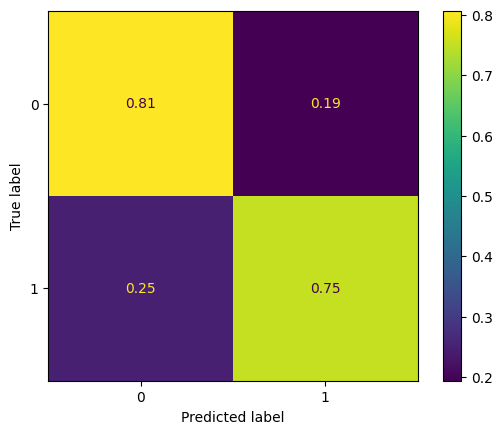

F1 score


0.7796333522327028

In [ ]:
df = df.join(wordvec_df, rsuffix="_wordvec")
X = df.drop(["labels","sentiment","text","clean_text_tokenized"], axis=1)
X.columns = X.columns.astype(str)
y = df["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rand_forest = RandomForestClassifier(n_estimators=200)
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)

mapping = {
    "negative": 0,
    "positive": 1 
}

cm = sklearn.metrics.confusion_matrix(y_test, y_pred, normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mapping.values())
disp.plot()
plt.show()

print("F1 score")
sklearn.metrics.f1_score(y_test, y_pred, average="macro")

In [ ]:
X_train

,postive_word_count,negative_word_count,avg_sentiment_of_words,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
788,0,0,0.000000,-0.083987,0.167567,-0.013903,0.094158,0.009361,-0.391326,0.212902,...,0.259859,0.175024,0.044683,0.041023,0.577383,0.303794,0.113059,-0.189854,0.210944,-0.133161
665,0,0,0.000000,-0.097367,0.233842,-0.039985,0.024291,0.013286,-0.510317,0.069123,...,0.468849,0.137159,0.106130,-0.035249,0.538400,0.362671,0.199985,-0.168142,0.155988,-0.095423
296,1,0,0.083333,-0.078339,0.251177,-0.066465,0.097017,0.084693,-0.429036,0.164119,...,0.313273,0.182215,0.093731,0.082011,0.547870,0.270005,0.102504,-0.199912,0.178806,-0.075298
567,0,0,0.000000,-0.016038,0.694970,-0.454067,0.258172,0.600959,-0.958745,-0.004153,...,1.021151,0.265612,0.443430,0.246002,0.707320,0.294535,0.020590,-0.397601,0.088567,0.075545
679,0,0,0.000000,-0.034025,0.278278,-0.150406,0.133868,0.194169,-0.497451,0.101517,...,0.413817,0.239989,0.150777,0.075453,0.540116,0.258642,0.049555,-0.238292,0.134418,-0.039334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,1,1,0.000000,-0.165435,0.229715,0.055462,0.064735,-0.018047,-0.370887,0.348512,...,0.286018,0.221092,-0.022420,0.020376,0.745684,0.347002,0.181210,-0.272083,0.306046,-0.030054
1095,0,0,0.000000,-0.065944,0.492062,-0.287900,0.166985,0.315374,-0.716803,0.010532,...,0.705191,0.239890,0.275107,0.149280,0.605430,0.281285,0.047278,-0.286613,0.099608,-0.024736
1130,1,0,0.100000,-0.149016,0.126417,0.066972,0.089806,-0.032072,-0.374965,0.284451,...,0.208844,0.203909,-0.026809,0.005294,0.622662,0.356849,0.148240,-0.207807,0.281360,-0.138495
860,0,1,-0.040000,0.048454,0.430789,-0.168816,0.135432,0.413521,-0.490823,0.204807,...,0.640580,0.290200,0.209668,0.183263,0.671704,0.142283,0.025507,-0.278868,0.200705,0.172852


Bronnen:

[1] Sinha, A. (2020). Sentiment analysis for financial news [Dataset]. Kaggle. Retrieved from https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

[2] Varun, D. (2018). Sentiment analysis using Word2Vec. Kaggle. Retrieved from https://www.kaggle.com/code/varun08/sentiment-analysis-using-word2vec

[3] Nitin, G. (2019). Twitter sentiment analysis - word2vec, doc2vec. Kaggle. Retrieved from https://www.kaggle.com/code/nitin194/twitter-sentiment-analysis-word2vec-doc2vec

[4] Kanad, P. (2024). Sentiment analysis word lists dataset [Dataset]. Kaggle. Retrieved from https://www.kaggle.com/datasets/prajwalkanade/sentiment-analysis-word-lists-dataset?resource=download